In [ ]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

np.random.seed(42)
random.seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 40.1 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=2d266c8c26ac23d8f61a5531ec2637dd845a8cc0f79b414aca140df24bc40918
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Работа с данными

In [ ]:
#train
train = pd.read_csv('/content/data_A.csv')
#val
val = pd.read_csv('/content/A_val.csv')
#test
test = pd.read_csv('/content/A_test.csv')

In [ ]:
test

,title,content,label
0,Biden Unveils Plan To Combat Threat Of Western...,President Joe Biden is meeting with the govern...,left
1,"Trump Praises Marjorie Taylor Greene, Who Just...",Former President Donald Trump shouted out Rep....,left
2,Over 40 People Have Been Arrested As Potential...,In the four weeks since a 21-year-old alleged ...,left
3,Politico Newsroom In Uproar Over Ben Shapiro’s...,Politico faced an internal uproar on Thursday ...,left
4,100 Experts Express ‘Growing Alarm’ That Repub...,More than 100 scholars have issued a dire warn...,left
...,...,...,...
5193,The Worst-Run Big City in the U.S.,As long as San Francisco is an alluring destin...,center
5194,"If Biden Wants Unity, He Should Emulate Bush I...","OPINION\n\nAs an American, I wish President Jo...",right
5195,Fact Checking Claims About GOP Senators Being ...,FACT CHECK\n\nA viral tweet claims to show a R...,center
5196,A Return to Reaganism for the GOP? Unlikely.,ANALYSIS\n\nThroughout Donald Trump’s captivit...,right


In [ ]:
data = train.append(val)
data = data.append(test)
data.shape

<ipython-input-4-c7a6733eceb6>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = train.append(val)
<ipython-input-4-c7a6733eceb6>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(test)


(55277, 3)

In [ ]:
data

,title,content,label
0,Kamala Harris’s Very Bad Trip South,OPINION\n\nKamala Harris was not happy about b...,right
1,Serving America's Veterans,Opinion\n\nTo my fellow veterans: Our country ...,right
2,Democrats seize on Mueller hearings in electio...,Democrats calling for action on election secur...,center
3,"Rubio: Biden's Rhetoric, 1st-Day Policies Crea...",President Joe Biden's rhetoric both before and...,right
4,FBI failed to follow Justice Department’s news...,FBI agents did not follow Justice Department g...,center
...,...,...,...
5193,The Worst-Run Big City in the U.S.,As long as San Francisco is an alluring destin...,center
5194,"If Biden Wants Unity, He Should Emulate Bush I...","OPINION\n\nAs an American, I wish President Jo...",right
5195,Fact Checking Claims About GOP Senators Being ...,FACT CHECK\n\nA viral tweet claims to show a R...,center
5196,A Return to Reaganism for the GOP? Unlikely.,ANALYSIS\n\nThroughout Donald Trump’s captivit...,right


Удаление NaN

In [ ]:
train = train.dropna()
val = val.dropna()
test = test.dropna()
data = data.dropna()

Взглянем на распределение по классам на всех данных

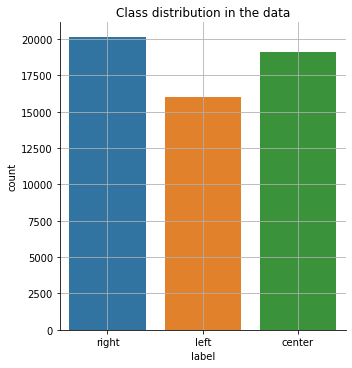

In [ ]:
g = sns.catplot(x='label',
                kind="count",
                data=data.sort_values("label")[::-1])
plt.grid()
plt.title("Class distribution in the data");

In [ ]:
train['all_text'] = train['title']+train['content']
val['all_text'] = val['title']+val['content']
test['all_text'] = test['title']+test['content']

#Лемматизация

In [ ]:
m = MorphAnalyzer()
regex = re.compile("[A-Za-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


mystopwords = stopwords.words('english') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [ ]:
from multiprocessing import Pool as PoolSklearn
#train
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, train['all_text']), total=len(train)))
    
train['lemmas'] = lemmas
train.sample(5)

#val
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, val['all_text']), total=len(val)))  
val['lemmas'] = lemmas
val.sample(5)

#test 
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, test['all_text']), total=len(test)))
    
test['lemmas'] = lemmas
test.sample(5)

100%|██████████| 5198/5198 [00:08<00:00, 620.34it/s]


,title,content,label,all_text,lemmas
4800,Judge: NSA domestic phone data-mining unconsti...,Opinion\n\nTo my fellow veterans: Our country ...,left,Judge: NSA domestic phone data-mining unconsti...,judge domestic phone data mining unconstitutio...
794,Russian missiles strike Lviv,Russia fired missiles at an airport near Lviv ...,center,Russian missiles strike LvivRussia fired missi...,russian missiles strike lvivrussia fired missi...
4951,McCarthy won't support January 6 commission an...,House Republican Leader Kevin McCarthy announc...,left,McCarthy won't support January 6 commission an...,mccarthy support january commission sides repu...
4315,Sarah Sanders becomes the latest ex-Trump offi...,New York (CNN Business)Former White House pres...,left,Sarah Sanders becomes the latest ex-Trump offi...,sarah sanders becomes latest trump official jo...
4122,Is same-sex marriage no longer a political issue?,OPINION\n\nSame sex marriage is a non-issue in...,left,Is same-sex marriage no longer a political iss...,marriage longer political issue opinion marria...


In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
train['label_enc'] = labelencoder.fit_transform(train['label'])
val['label_enc'] = labelencoder.transform(val['label'])
test['label_enc'] = labelencoder.transform(test['label'])
train

,title,content,label,all_text,lemmas,label_enc
0,Kamala Harris’s Very Bad Trip South,OPINION\n\nKamala Harris was not happy about b...,right,Kamala Harris’s Very Bad Trip SouthOPINION\n\n...,kamala harris trip southopinion kamala harris ...,2
1,Serving America's Veterans,Opinion\n\nTo my fellow veterans: Our country ...,right,Serving America's VeteransOpinion\n\nTo my fel...,serving america veteransopinion fellow veteran...,2
2,Democrats seize on Mueller hearings in electio...,Democrats calling for action on election secur...,center,Democrats seize on Mueller hearings in electio...,democrats seize mueller hearings election secu...,0
3,"Rubio: Biden's Rhetoric, 1st-Day Policies Crea...",President Joe Biden's rhetoric both before and...,right,"Rubio: Biden's Rhetoric, 1st-Day Policies Crea...",rubio biden rhetoric policies created border c...,2
4,FBI failed to follow Justice Department’s news...,FBI agents did not follow Justice Department g...,center,FBI failed to follow Justice Department’s news...,failed follow justice department news media gu...,0
...,...,...,...,...,...,...
45066,White House Adviser Says Trump Working on Back...,A top White House adviser said President Trump...,center,White House Adviser Says Trump Working on Back...,white house adviser says trump working backgro...,0
45067,"Once, Talk of an Enemies List Was Shocking",Now candidates openly speak of being proud of ...,center,"Once, Talk of an Enemies List Was ShockingNow ...",talk enemies list shockingnow candidates openl...,0
45068,New White House press secretary makes false cl...,FACT CHECK\n\nAt the first official briefing b...,left,New White House press secretary makes false cl...,white house press secretary makes false claims...,1
45069,Audit finds bloated budget for green jobs trai...,A federal audit shows that nearly a half-billi...,right,Audit finds bloated budget for green jobs trai...,audit finds bloated budget green jobs training...,2


Объеденим датасеты

In [ ]:
data = train.append(val)
data = data.append(test)
data.shape

<ipython-input-12-c7a6733eceb6>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = train.append(val)
<ipython-input-12-c7a6733eceb6>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(test)


(55277, 6)

# Tf-Idf для кластеризации

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(ngram_range=(1, 2))
data_vec = vec.fit_transform(data['lemmas'])

In [ ]:
data_vec.shape

(55277, 1338429)

# Кластеризация

Метод к-средних

In [ ]:
num_clusters = 5
from sklearn.cluster import KMeans

km = KMeans(n_clusters=num_clusters)
idx = km.fit(data_vec)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
clusterkm  = km.labels_.tolist()

In [ ]:
clusterkm = km.labels_.tolist()
out = { 'title': data['title'].tolist(), 'cluster': clusterkm, 'text': data['content'].tolist() }
frame1 = pd.DataFrame(out, index = np.arange(len(clusterkm)), columns = ['title', 'cluster','text'])

In [ ]:
frame1['cluster'].value_counts()

1    39662
3     9908
0     2471
2     2190
4     1046
Name: cluster, dtype: int64

Применим PCA для возможности отобразить результаты кластеризации

In [ ]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=2)

In [ ]:
pca.fit(data_vec)

TruncatedSVD()

In [ ]:
data_2  = pca.transform(data_vec)

In [ ]:
#создаем data frame, который содержит координаты (из PCA) + номера кластеров и сами запросы
df = pd.DataFrame(dict(x=data_2[:,0], y=data_2[:,1], label=clusterkm, title=data['title'].tolist())) 
#группируем по кластерам
groups = df.groupby('label',sort=False)

In [ ]:
cluster_colors = {0: 'blue',1: '#FFA812', 2: 'magenta',  3: 'green', 4: 'red'}
cluster_names = {0: 'Finance', 1: 'Others', 2: 'Domestic policy',  3: 'Elections', 4: 'Foreign policy'}

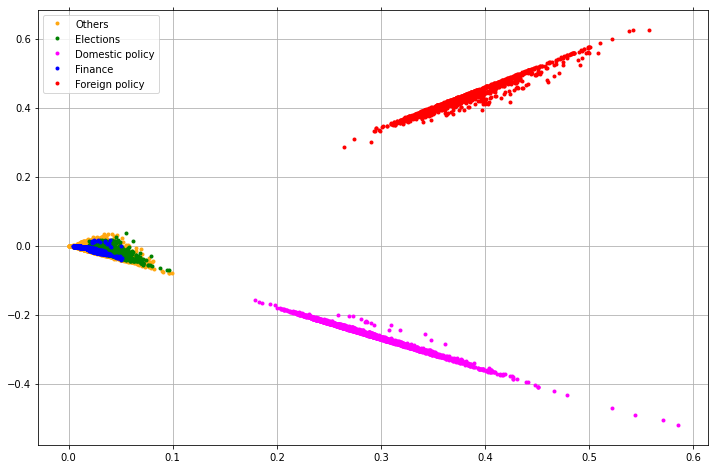

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',          
        which='both',      
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(        axis= 'y',         
        which='both',     
        left='off',      
        top='off',       
        labelleft='off')
plt.grid(which='both')    
ax.legend(numpoints=1)
plt.show() 

In [ ]:
def alert(row):
  if row['cluster'] == 0:
    return 'Finance'
  elif row['cluster'] == 1:
    return 'Others'
  elif row['cluster'] == 2:
    return 'Domestic policy' 
  elif row['cluster'] == 3: 
    return 'Elections'
  else:
    return 'Foreign policy'


frame1['news_cluster'] = frame1.apply(alert, axis=1)

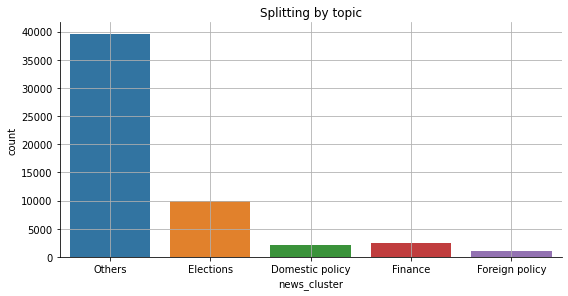

In [ ]:
g = sns.catplot(x='news_cluster',
                kind="count",
                data=frame1, height = 4, aspect = 2,)
plt.grid(which='both')
plt.title("Splitting by topic");

Делим на test, train и val

In [ ]:
data

,title,content,label,all_text,lemmas,label_enc
0,Kamala Harris’s Very Bad Trip South,OPINION\n\nKamala Harris was not happy about b...,right,Kamala Harris’s Very Bad Trip SouthOPINION\n\n...,kamala harris trip southopinion kamala harris ...,2
1,Serving America's Veterans,Opinion\n\nTo my fellow veterans: Our country ...,right,Serving America's VeteransOpinion\n\nTo my fel...,serving america veteransopinion fellow veteran...,2
2,Democrats seize on Mueller hearings in electio...,Democrats calling for action on election secur...,center,Democrats seize on Mueller hearings in electio...,democrats seize mueller hearings election secu...,0
3,"Rubio: Biden's Rhetoric, 1st-Day Policies Crea...",President Joe Biden's rhetoric both before and...,right,"Rubio: Biden's Rhetoric, 1st-Day Policies Crea...",rubio biden rhetoric policies created border c...,2
4,FBI failed to follow Justice Department’s news...,FBI agents did not follow Justice Department g...,center,FBI failed to follow Justice Department’s news...,failed follow justice department news media gu...,0
...,...,...,...,...,...,...
5193,The Worst-Run Big City in the U.S.,As long as San Francisco is an alluring destin...,center,The Worst-Run Big City in the U.S.As long as S...,worst city long francisco alluring destination...,0
5194,"If Biden Wants Unity, He Should Emulate Bush I...","OPINION\n\nAs an American, I wish President Jo...",right,"If Biden Wants Unity, He Should Emulate Bush I...",biden wants unity emulate bush instead obamaop...,2
5195,Fact Checking Claims About GOP Senators Being ...,FACT CHECK\n\nA viral tweet claims to show a R...,center,Fact Checking Claims About GOP Senators Being ...,fact checking claims senators loyal putinfact ...,0
5196,A Return to Reaganism for the GOP? Unlikely.,ANALYSIS\n\nThroughout Donald Trump’s captivit...,right,A Return to Reaganism for the GOP? Unlikely.AN...,return reaganism unlikely analysis throughout ...,2


In [ ]:
from sklearn.model_selection import train_test_split as tts

df_train = data[['title','lemmas','content','label','all_text','label_enc']]
y_train = data['label_enc']
train, test, y_train, y_test = tts(df_train, y_train, shuffle=True, stratify=y_train, train_size=0.815)  

In [ ]:
test, val, y_test, y_val = tts(test, y_test, shuffle=True, stratify=y_test, train_size=0.5) 

In [ ]:
test.to_csv('A_test_new.csv', index = False)

In [ ]:
train.to_csv('A_train_new.csv', index = False)

In [ ]:
val.to_csv('A_val_new.csv', index = False)

# Классификация

## Tf-Idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vec = TfidfVectorizer(ngram_range=(1, 3))
train_vec = vec.fit_transform(train['lemmas'])
test_vec = vec.transform(test['lemmas'])
val_vec = vec.transform(val['lemmas'])

In [ ]:
y_train = train['label_enc']
y_test = test['label_enc']
y_val = val['label_enc']

## Baseline

In [ ]:
from sklearn.svm import LinearSVC
clf_1 = LinearSVC()
clf_1.fit(train_vec, y_train)

LinearSVC()

In [ ]:
scores_F1 ={}
scores_MAE ={}
scores_Accuracy = {}

In [ ]:
import tensorflow as tf

y_pred = clf_1.predict(test_vec)
test_y = tf.keras.utils.to_categorical(
    test['label_enc'], num_classes=3)
y_proba_cb = clf_1._predict_proba_lr(test_vec)

In [ ]:
from sklearn.metrics import f1_score ,mean_absolute_error, accuracy_score

print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['Baseline'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['Baseline'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['Baseline'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.5832739494493436
Accuracy: 0.5869352630549579
MAE: 0.39923479570331377


## LightGBM

In [ ]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()

In [ ]:
clf.fit(train_vec, y_train)

LGBMClassifier()

In [ ]:
import tensorflow as tf

y_pred = clf.predict(test_vec)
test_y = tf.keras.utils.to_categorical(
    test['label_enc'], num_classes=3)
y_proba_cb = clf.predict_proba(test_vec)

In [ ]:
from sklearn.metrics import f1_score ,mean_absolute_error, accuracy_score

print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['LightGBM'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['LightGBM'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['LightGBM'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.5498506635859214
Accuracy: 0.5556424799530608
MAE: 0.3757745050926962


## BERT

In [ ]:
train.loc[train["lemmas"] == "", "lemmas"] = np.nan
test.loc[test["lemmas"] == "", "lemmas"] = np.nan
val.loc[val["lemmas"] == "", "lemmas"] = np.nan

In [ ]:
train = train.dropna()
val = val.dropna()
test = test.dropna()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45050 entries, 23645 to 26826
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      45050 non-null  object
 1   lemmas     45050 non-null  object
 2   content    45050 non-null  object
 3   label      45050 non-null  object
 4   all_text   45050 non-null  object
 5   label_enc  45050 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.4+ MB


In [ ]:
y_train = train['label_enc']
y_test = test['label_enc']
y_val = val['label_enc']

In [ ]:
!pip install tensorflow_hub
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 96.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
def build_classifier_model():
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name='preprocessing')
    
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(
        3, activation='softmax', name='classifier')(net)
    model = tf.keras.Model(text_input, net)
    
    loss = tf.keras.losses.SquaredHinge(name='squared_hinge')
    metric = tf.metrics.CategoricalAccuracy('accuracy')
    optimizer = Adam(
        learning_rate=4e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
    model.compile(
        optimizer=optimizer, loss=loss, metrics=metric)
    model.summary()
    return model

In [ ]:
tfhub_handle_encoder = \
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = \
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [ ]:
classifier_model = build_classifier_model()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
y_train = tf.keras.utils.to_categorical(
    train['label_enc'], num_classes=3)
y_val = tf.keras.utils.to_categorical(
    val['label_enc'], num_classes=3)

history = classifier_model.fit(
    x = train['lemmas'].values,
    y = y_train,
    validation_data=(val['lemmas'].values, y_val),
    epochs=10)

Epoch 1/10
1408/1408 [==============================] - 369s 252ms/step - loss: 1.2470 - accuracy: 0.5001 - val_loss: 1.2074 - val_accuracy: 0.5465
Epoch 2/10
1408/1408 [==============================] - 330s 234ms/step - loss: 1.2035 - accuracy: 0.5490 - val_loss: 1.1971 - val_accuracy: 0.5567
Epoch 3/10
1408/1408 [==============================] - 330s 234ms/step - loss: 1.1914 - accuracy: 0.5628 - val_loss: 1.1931 - val_accuracy: 0.5624
Epoch 4/10
1408/1408 [==============================] - 332s 236ms/step - loss: 1.1844 - accuracy: 0.5684 - val_loss: 1.1882 - val_accuracy: 0.5665
Epoch 5/10
1408/1408 [==============================] - 327s 232ms/step - loss: 1.1787 - accuracy: 0.5746 - val_loss: 1.1867 - val_accuracy: 0.5671
Epoch 6/10
1408/1408 [==============================] - 325s 231ms/step - loss: 1.1754 - accuracy: 0.5782 - val_loss: 1.1854 - val_accuracy: 0.5675
Epoch 7/10
1408/1408 [==============================] - 329s 234ms/step - loss: 1.1725 - accuracy: 0.5790 - val_

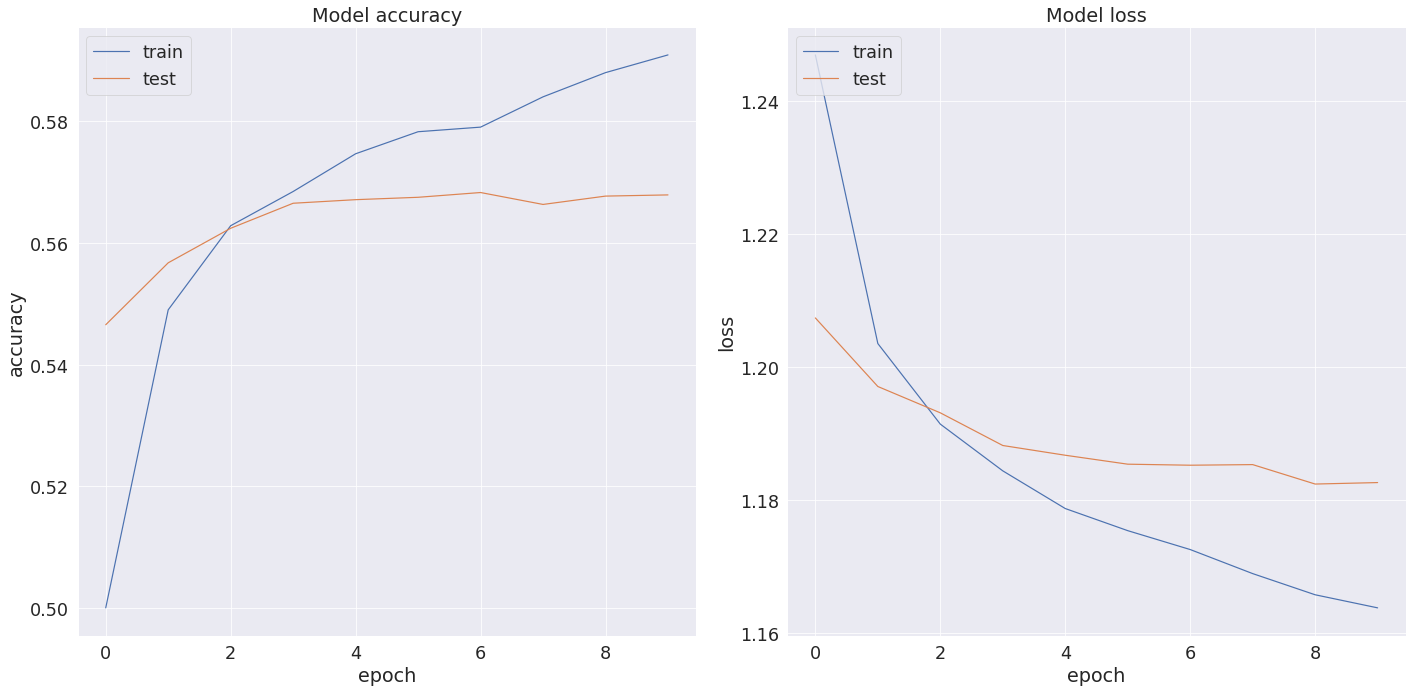

In [ ]:
sns.set()
sns.set_context("paper", font_scale=2) 

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
sns.lineplot(ax=ax1, data=history.history['accuracy'])
sns.lineplot(ax=ax1, data=history.history['val_accuracy'])
ax1.set(
    title=f"Model accuracy",
    xlabel="epoch",
    ylabel="accuracy"
)
ax1.legend(['train', 'test'], loc='upper left')
ax2 = fig.add_subplot(122)
sns.lineplot(ax=ax2, data=history.history['loss'])
sns.lineplot(ax=ax2, data=history.history['val_loss'])
ax2.set(
    title=f"Model loss",
    xlabel="epoch",
    ylabel="loss"
)
ax2.legend(['train', 'test'], loc='upper left')

fig.tight_layout()
plt.show(fig) 

In [ ]:
y_test = tf.keras.utils.to_categorical(
    test['label_enc'].astype('category'), num_classes=3)

In [ ]:
y_proba_cb  = classifier_model.predict(test['lemmas'].values)
y_pred = np.argmax(y_proba_cb, axis=1)
test_y = tf.keras.utils.to_categorical(
    test['label_enc'], num_classes=3)

160/160 [==============================] - 17s 104ms/step


In [ ]:
from sklearn.metrics import f1_score ,mean_absolute_error, accuracy_score

print('F1:',f1_score(y_pred, np.argmax(y_test,axis = 1), average='macro'))
scores_F1['BERT'] = f1_score(y_pred, np.argmax(y_test,axis = 1), average='macro')
print('Accuracy:',accuracy_score(y_pred, np.argmax(y_test,axis = 1)))
scores_Accuracy['BERT'] = accuracy_score(y_pred, np.argmax(y_test,axis = 1))
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['BERT'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.5620273813686302
Accuracy: 0.5699198122433013
MAE: 0.30896634


## Catboost

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 15.2 MB/s eta 0:00:00


In [ ]:
train

,title,lemmas,content,label,all_text,label_enc
23645,‘We can get through this’: How to manage your ...,manage mental health coronavirus pandemicthe c...,The coronavirus pandemic poses an obvious thre...,center,‘We can get through this’: How to manage your ...,0
38223,"In 24 Hours, Netflix Could Lose Almost 25% Of ...",hours netflix could lose almost subscribersit ...,It was Netflix’s most embarrassing day ever.\n...,center,"In 24 Hours, Netflix Could Lose Almost 25% Of ...",0
9206,Anxious About Election Results? Here’s What’s ...,anxious election results happening brain waita...,ANALYSIS\n\nIf you’re feeling nervous about th...,center,Anxious About Election Results? Here’s What’s ...,0
32342,How to Keep Track of All the Potential Coronav...,keep track potential coronavirus treatmentsthe...,"There’s still no cure for the coronavirus, but...",center,How to Keep Track of All the Potential Coronav...,0
31657,Parsons Green: Underground blast a terror inci...,parsons green underground blast terror inciden...,Analysis\n\nHow 3 presidents announced the dea...,center,Parsons Green: Underground blast a terror inci...,0
...,...,...,...,...,...,...
19246,Primary Preview: Five Races to Watch,primary preview five races watchtoday brings b...,Today brings the biggest primary day of the se...,center,Primary Preview: Five Races to WatchToday brin...,0
16979,"Republicans pass tax breaks, but don’t pay for...",republicans pass breaks themrepublicans want d...,Republicans want to cut the deficit. And Repub...,left,"Republicans pass tax breaks, but don’t pay for...",1
31802,Sarah Huckabee Sanders Berated Staffers Over M...,sarah huckabee sanders berated staffers mccain...,News\n\nWhat to expect as Democrats retain the...,left,Sarah Huckabee Sanders Berated Staffers Over M...,1
4756,"Barcelona terror attack death toll rises, four...",barcelona terror attack death toll rises fourt...,A fourth person was arrested on Friday in conn...,right,"Barcelona terror attack death toll rises, four...",2


Добавим переменную длинна всего текста

In [ ]:
train['sym_len'] = train.lemmas.apply(len)
train['word_len'] = train.lemmas.apply(lambda x: len(x.split()))

val['sym_len'] = val.lemmas.apply(len)
val['word_len'] = val.lemmas.apply(lambda x: len(x.split()))

test['sym_len'] = test.lemmas.apply(len)
test['word_len'] = test.lemmas.apply(lambda x: len(x.split()))

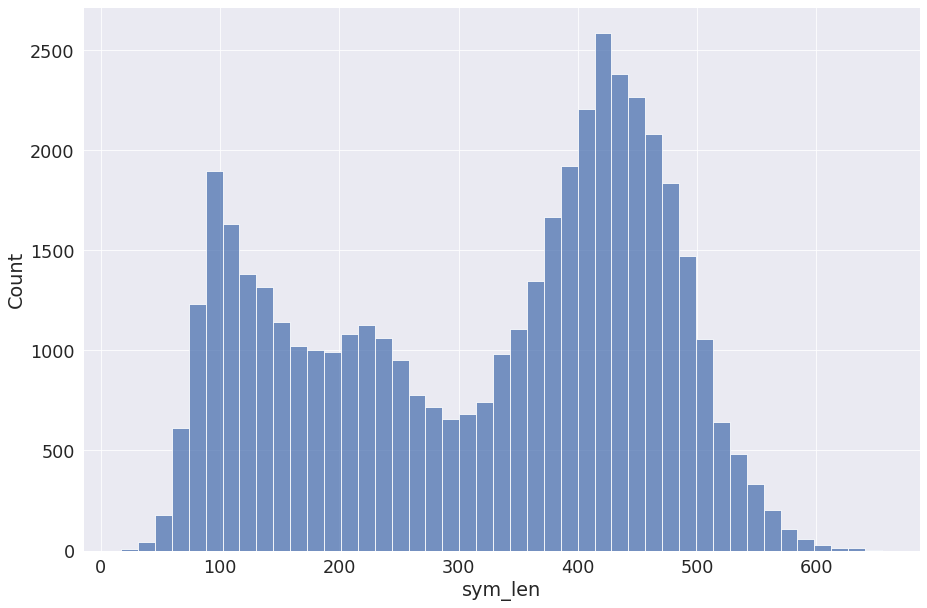

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(data=train.sym_len)
plt.show()

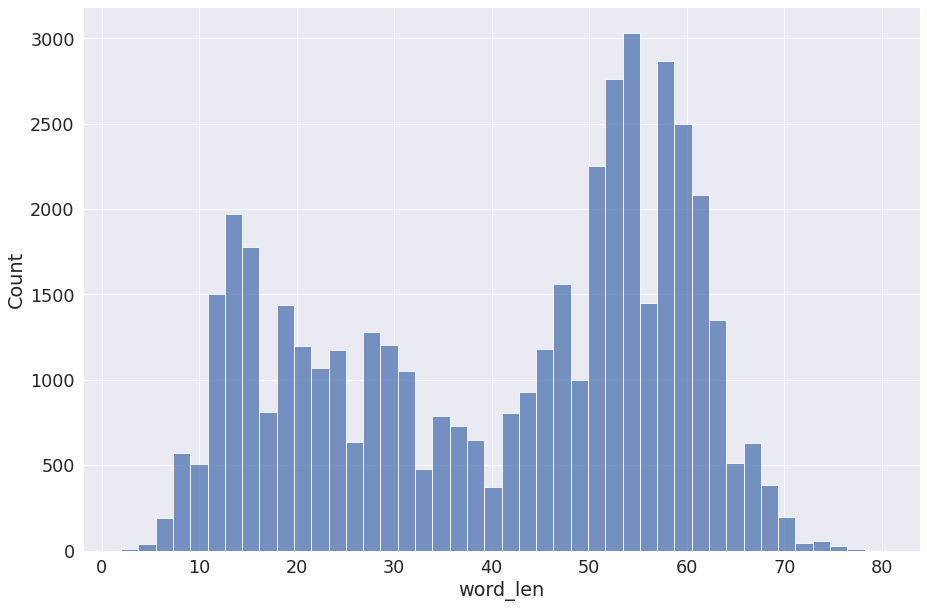

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(data=train.word_len)
plt.show()

In [ ]:
df_train = train[['title','all_text','lemmas','content','sym_len', 'word_len']]
y_train = train['label_enc']
df_val = val[['title','all_text','lemmas','content','sym_len', 'word_len']]
y_val = val['label_enc']
df_test = test[['title','all_text','lemmas','content','sym_len', 'word_len']]
y_test = test['label_enc']

In [ ]:
from catboost import CatBoostClassifier
from catboost import Pool


def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        iterations=10000,
        learning_rate=0.1,
        use_best_model= True,
        task_type='GPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=500,
    )

In [ ]:
train_pool = Pool(
    df_train, y_train, 
    text_features=['title','all_text','lemmas','content'],
)

validation_pool = Pool(
    df_val, y_val, 
    text_features=['title','all_text','lemmas','content'],
)

test_pool = Pool(
    df_test, y_test, 
    text_features=['title','all_text','lemmas','content'],
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

model = fit_model(train_pool, validation_pool)

Train dataset shape: (45050, 6)

0:	learn: 1.0630197	test: 1.0601750	best: 1.0601750 (0)	total: 48.5ms	remaining: 8m 4s
500:	learn: 0.7139164	test: 0.7335400	best: 0.7335400 (500)	total: 9.75s	remaining: 3m 4s
1000:	learn: 0.6667303	test: 0.7191575	best: 0.7191575 (1000)	total: 18.9s	remaining: 2m 49s
1500:	learn: 0.6313388	test: 0.7123536	best: 0.7123536 (1500)	total: 26.2s	remaining: 2m 28s
2000:	learn: 0.6015062	test: 0.7063368	best: 0.7063368 (2000)	total: 36.9s	remaining: 2m 27s
2500:	learn: 0.5763293	test: 0.7038118	best: 0.7038118 (2500)	total: 46.1s	remaining: 2m 18s
3000:	learn: 0.5534409	test: 0.7021887	best: 0.7021670 (2992)	total: 54s	remaining: 2m 5s
3500:	learn: 0.5333493	test: 0.7003187	best: 0.7003187 (3500)	total: 1m 2s	remaining: 1m 55s
4000:	learn: 0.5140863	test: 0.6989551	best: 0.6988964 (3995)	total: 1m 11s	remaining: 1m 46s
4500:	learn: 0.4969014	test: 0.6975299	best: 0.6974737 (4461)	total: 1m 22s	remaining: 1m 40s
5000:	learn: 0.4808983	test: 0.6972257	best: 0.

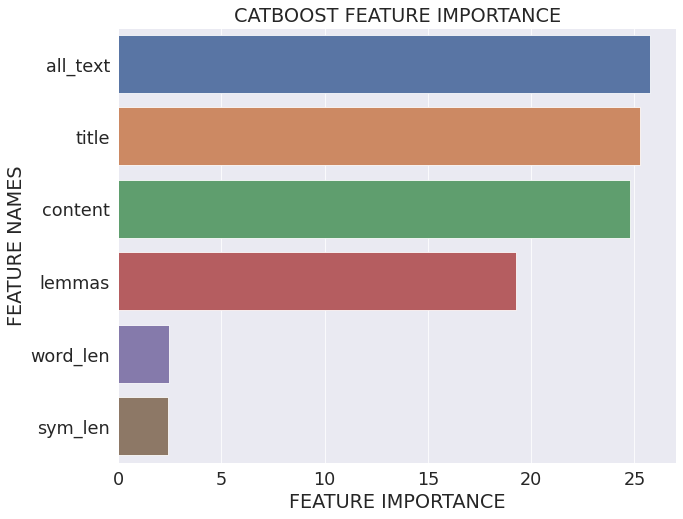

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
#plot the catboost result
plot_feature_importance(model.get_feature_importance(),df_train.columns,'CATBOOST ')

In [ ]:
y_proba_cb = model.predict_proba(test_pool)
y_pred = np.argmax(y_proba_cb, axis=1)

In [ ]:
test_y = tf.keras.utils.to_categorical(
    test['label_enc'], num_classes=3)

Итоговые метрики

In [ ]:
print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['Catboost'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['Catboost'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['Catboost'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.6975959034990029
Accuracy: 0.7005671816937219
MAE: 0.2704399580223627


Матрицы ошибок

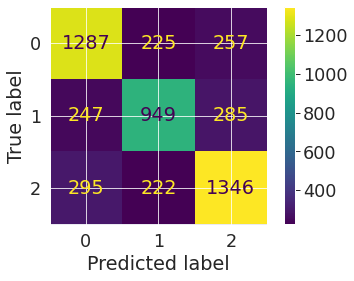

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

<AxesSubplot:>

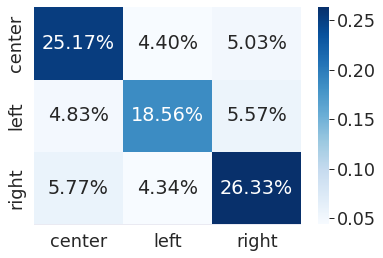

In [ ]:
target_names = ['center', 'left', 'right']
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%', cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names)

In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      center       0.70      0.73      0.72      1769
        left       0.68      0.64      0.66      1481
       right       0.71      0.72      0.72      1863

    accuracy                           0.70      5113
   macro avg       0.70      0.70      0.70      5113
weighted avg       0.70      0.70      0.70      5113



## XLNet

In [ ]:
!pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences

from pytorch_transformers import XLNetTokenizer
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import io

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
sentences = train['lemmas']

In [ ]:
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = train['label_enc']

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁manage', '▁mental', '▁health', '▁', 'corona', 'virus', '▁pandemic', 'the', '▁', 'corona', 'virus', '▁pandemic', '▁poses', '▁obvious', '▁threat', '▁physical', '▁safety', '▁advocates', '▁stress', '▁', 'american', 's', '▁sleep', '▁mental', '▁health', '▁york', '▁and', 'rew', '▁', 'cu', 'omo', '▁', 'democrat', '▁whose', '▁state', '▁become', '▁epicenter', '▁co', 'vid', '▁crisis', '▁said', '▁we', 'd', 'nes', 'day', '▁mental', '▁health', '▁professionals', '▁volunteered', '▁provide', '▁free', '▁mental', '▁health', '▁services', '▁empire', '▁state', '▁least', '▁confirmed', '▁cases', '▁', 'mon', 'day', '▁morning', '▁four', '▁days', '▁making', '▁', 'disproportionate', '▁share', '▁united', '▁states', '▁confirmed', '▁cases', '▁york', '▁city', '▁accounts', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [ ]:
MAX_LEN = 128

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
train_inputs = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
train_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in train_inputs:
  seq_mask = [float(i>0) for i in seq]
  train_masks.append(seq_mask)

In [ ]:
sentences_val = val['lemmas']

In [ ]:
sentences_val = [sentence + " [SEP] [CLS]" for sentence in sentences_val]
labels_val = val['label_enc']

In [ ]:
tokenized_texts_val = [tokenizer.tokenize(sent) for sent in sentences_val]

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_val]

In [ ]:
validation_inputs = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
validation_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in validation_inputs:
  seq_mask = [float(i>0) for i in seq]
  validation_masks.append(seq_mask)

In [ ]:
labels = np.array(train['label_enc'])

In [ ]:
labels_val =  np.array(val['label_enc'])

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(labels)
validation_labels = torch.tensor(labels_val)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 102.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 23.0 MB/s eta 0:00:00


In [ ]:
from transformers import XLNetForSequenceClassification

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=3)
model.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
train_loss_set = []

epochs = 4

for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    loss.backward()
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  model.eval()


  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 1.1006091198968617


Epoch:  25%|██▌       | 1/4 [20:40<1:02:02, 1240.98s/it]

Validation Accuracy: 0.44722055288461543
Train loss: 0.9948338379829444


Epoch:  50%|█████     | 2/4 [41:21<41:21, 1240.83s/it]  

Validation Accuracy: 0.5505859375
Train loss: 0.8623702940531075


Epoch:  75%|███████▌  | 3/4 [1:02:03<20:41, 1241.22s/it]

Validation Accuracy: 0.602373798076923
Train loss: 0.7488819937306371


Epoch: 100%|██████████| 4/4 [1:22:44<00:00, 1241.14s/it]

Validation Accuracy: 0.5993990384615385


In [ ]:
sentences = test['lemmas']

sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
#labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

model.eval()
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch
  with torch.no_grad():
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
print('F1:',f1_score(flat_predictions, y_test, average='macro'))
scores_F1['XLNet'] = f1_score(flat_predictions, y_test, average='macro')
print('Accuracy:',accuracy_score(flat_predictions, y_test))
scores_Accuracy['XLNet'] = accuracy_score(flat_predictions, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['XLNet'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.6087325385532667
Accuracy: 0.608644631331899
MAE: 0.2704399580223627


#Результаты

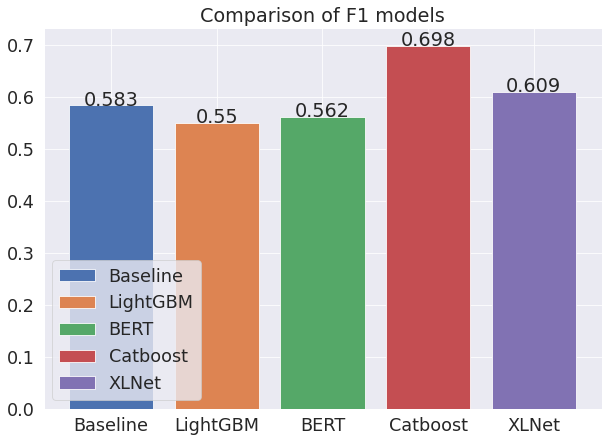

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
for i in scores_F1.keys():
  ax.bar(i,scores_F1[i], label=i)
  plt.text(i,scores_F1[i],round(scores_F1[i],3), ha = 'center')
ax.legend(loc='lower left')
plt.title("Comparison of F1 models")
plt.show()

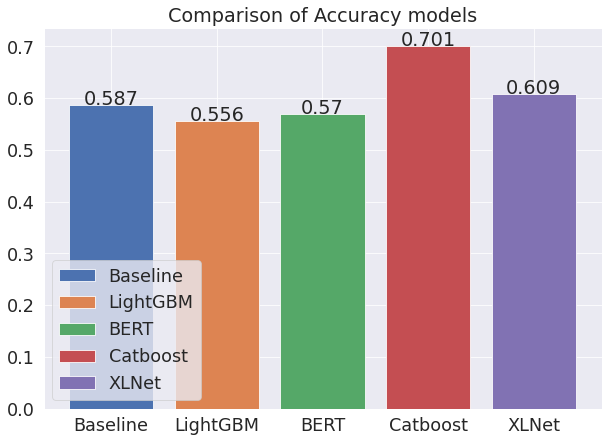

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
for i in scores_Accuracy.keys():
  ax.bar(i,scores_Accuracy[i], label=i)
  plt.text(i,scores_Accuracy[i],round(scores_Accuracy[i],3), ha = 'center')
ax.legend(loc='lower left')
plt.title("Comparison of Accuracy models")
plt.show()

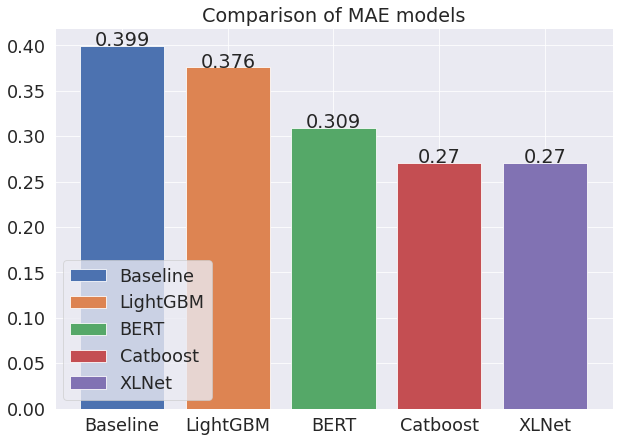

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
for i in scores_MAE.keys():
  ax.bar(i,scores_MAE[i], label=i)
  plt.text(i,scores_MAE[i],round(scores_MAE[i],3), ha = 'center')
ax.legend(loc='lower left')
plt.title("Comparison of MAE models")
plt.show()